!pip install -q git+https://github.com/mansaluke/newsai.git

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import *
import re
from typing import *
from scipy import linalg
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
import os
import sys

In [3]:
from newsai import dfconvert
from newsai.utils.nlp import *

2020-05-14 19:40:03,951 - newsai.dfconvert - INFO - Ipython active
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mcleary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\mcleary/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from newsai import _DATA_PATH

In [5]:
os.listdir(_DATA_PATH)

['all_stories.csv',
 'glue',
 'historicals.csv',
 'million-headlines',
 'stsbenchmark',
 'test.csv']

In [9]:
fpath = os.path.join(_DATA_PATH, 'historicals.csv')
df = pd.read_csv(fpath, encoding = "UTF-8", parse_dates=['date'])

In [10]:
df.head()

,H1,H2,date,alias,url
0,"Attacks have been traditionally underreported,...",When slurs were spray-painted on a kosher mark...,2020-01-03 10:00:23+00:00,nytimes,https://api.nytimes.com/svc/archive/v1/2020/1....
1,He deftly manipulated electronic images to pro...,"Woody Vasulka, an experimental video artist wh...",2020-01-01 18:49:54+00:00,nytimes,https://api.nytimes.com/svc/archive/v1/2020/1....
2,The past definitely wasn’t past for directors ...,"It’s Oscar time, which means everything new is...",2020-01-02 15:00:11+00:00,nytimes,https://api.nytimes.com/svc/archive/v1/2020/1....
3,Forget fad diets and fitness gimmicks. Just st...,"Daytime television talk shows, popular podcast...",2020-01-03 10:00:34+00:00,nytimes,https://api.nytimes.com/svc/archive/v1/2020/1....
4,Linda Tracy and Peter Tracy had been married 3...,When Donna Adelsberg ran into her best friend’...,2020-01-03 11:00:09+00:00,nytimes,https://api.nytimes.com/svc/archive/v1/2020/1....


In [7]:
df.describe()

,H1,H2,date,alias,url
count,21324,21161,21526,21526,21526
unique,11360,10568,10946,1,3
top,Here’s what you need to know.,To the Editor:,2020-03-18 22:41:15+00:00,nytimes,https://api.nytimes.com/svc/archive/v1/2020/1....
freq,145,289,21,21526,7585
first,NaN,NaN,2020-01-01 00:14:41+00:00,NaN,NaN
last,NaN,NaN,2020-04-01 07:00:10+00:00,NaN,NaN


In [8]:
df = remove_null_rows(df, ["H1", "H2"])

2020-05-13 15:45:58,761 - newsai.utils.nlp - INFO - Removing 1010 rows with nulls


In [9]:
headlines = series_to_string(df['H1'])

In [10]:
top_words = get_top_n_words(headlines, 20)

In [11]:
get_top_n_words(headlines, 10)

[(('new',), 1131),
 (('president',), 596),
 (('need',), 469),
 (('one',), 445),
 (('know',), 435),
 (('said',), 424),
 (('time',), 390),
 (('coronavirus',), 366),
 (('mr',), 357),
 (('here’s',), 348)]

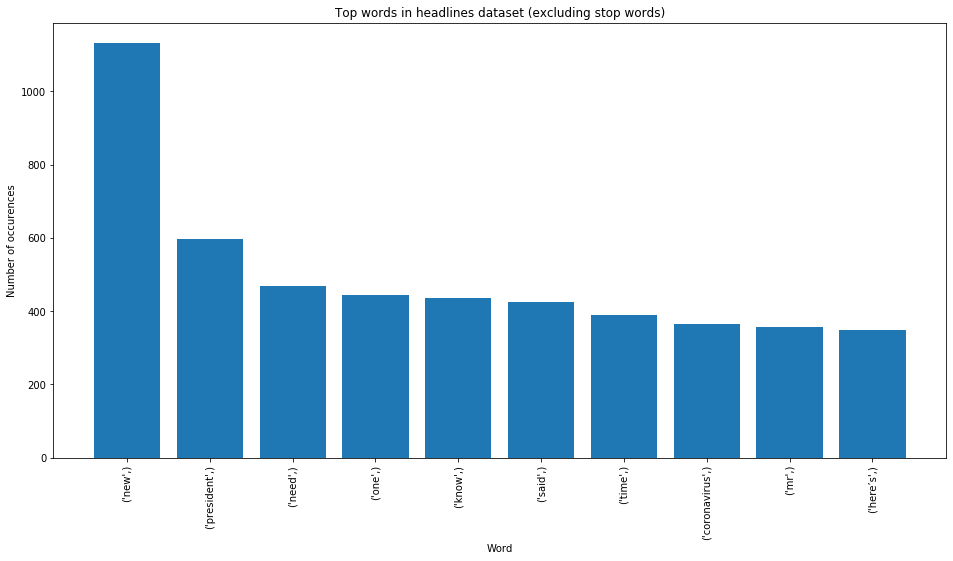

In [12]:
top_words = dict(top_words)
words, word_values = top_words.keys(), top_words.values()

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

In [13]:
top_words = get_top_n_words(headlines, 20, 2)
top_words[:10]

[(('need', 'know'), 373),
 (('new', 'york'), 287),
 (('here’s', 'need'), 267),
 (('president', 'trump'), 186),
 (('quotation', 'day'), 143),
 (('correction', 'appeared'), 143),
 (('appeared', 'print'), 143),
 (('see', 'look'), 143),
 (('couple', 'met'), 109),
 (('know', 'end'), 103)]

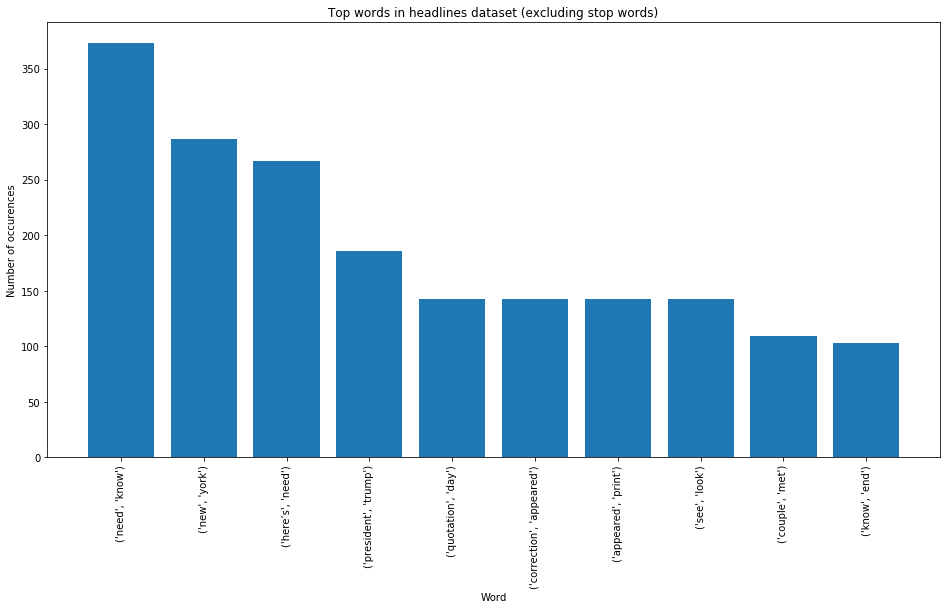

In [14]:
top_words = dict(top_words)
words, word_values = top_words.keys(), top_words.values()

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

In [21]:
get_total_word_count(headlines)

103112

In [22]:
df['word_count'] = df['H1'].str.len().fillna(0).astype(int)

In [23]:
df.word_count.mean()

121.34848058525606

In [24]:
reindexed_data = df['H1']
reindexed_data.index = df['date']

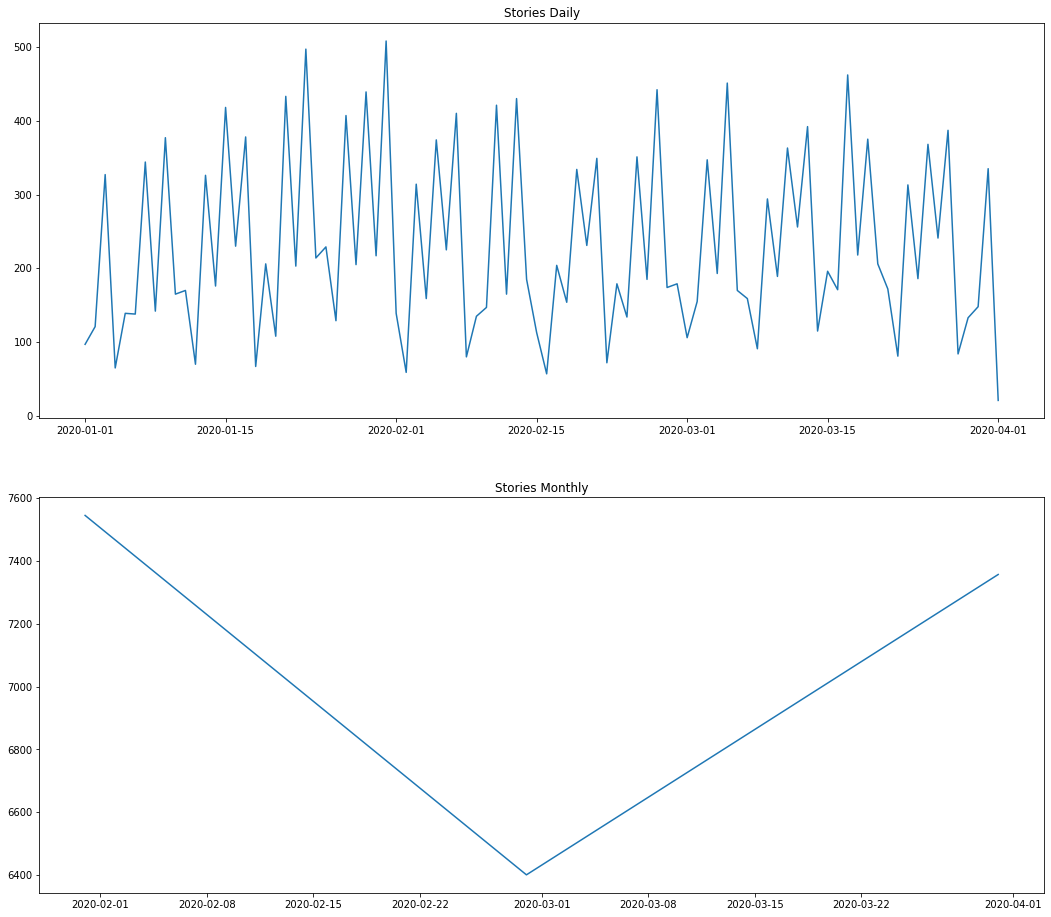

In [25]:
stories_daily = reindexed_data.resample('D').count()
stories_monthly = reindexed_data.resample('M').count()

fig, ax = plt.subplots(2, figsize=(18,16))
ax[0].plot(stories_daily)
ax[0].set_title('Stories Daily')
ax[1].plot(stories_monthly[:-1])
ax[1].set_title('Stories Monthly')
plt.show()

In [26]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)

small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: He proposed while fellow alumni from the Colgate 13, an all-male college a cappella group he once belonged to, sang backup.
Headline after vectorization: 
  (0, 6508)	1
  (0, 11254)	1
  (0, 5590)	1
  (0, 755)	1
  (0, 2900)	1
  (0, 19)	1
  (0, 8745)	1
  (0, 2923)	1
  (0, 2305)	1
  (0, 1571)	1
  (0, 12584)	1
  (0, 1325)	1


In [29]:
df.headlines = df.H1.apply(text_to_word_list)

In [30]:
texts = [headline for headline in df.headlines]
# Count word frequencies
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
# Only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]

In [31]:
from gensim import corpora

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)

Dictionary(14083 unique tokens: ['attack', 'begin', 'better', 'crime', 'data']...)


In [32]:
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]

In [33]:
from gensim import models

# train the model
tfidf = models.TfidfModel(bow_corpus)

In [34]:
from gensim import similarities
nf=len(dictionary.dfs)
index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=nf)

In [35]:
query_document = 'stock prices are rising'.split()
query_bow = dictionary.doc2bow(query_document)
sims = index[tfidf[query_bow]]

In [36]:
for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True):
    if score>0.3:
        print(f'doc num: {document_number} score: {score}')
        print(processed_corpus[document_number])


doc num: 19567 score: 0.3600307106971741
['flemish', 'tourist', 'bruges', 'housing', 'stock', 'slow', 'change', 'price', 'rising', 'along', 'demand']
doc num: 20094 score: 0.3600307106971741
['flemish', 'tourist', 'bruges', 'housing', 'stock', 'slow', 'change', 'price', 'rising', 'along', 'demand']


In [37]:
processed_corpus[:1]

[['attack',
  'traditionally',
  'fighting',
  'scourge',
  'hate',
  'crime',
  'begin',
  'better',
  'data',
  'expert',
  'say']]

In [38]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count

In [39]:
%time word2vec_model = Word2Vec(processed_corpus, size=100, window=5, min_count=5, workers=3, sg=0)


Wall time: 4.94 s


In [41]:

print("Embedding for stock:", word2vec_model.wv["stock"])

print("\nFirst 30 vocabulary words:", list(word2vec_model.wv.vocab)[:20])

# word2vec_model.wv.save_word2vec_format(SAVE_FILES_PATH# +"word2vec_model", binary=True)  # binary format
# word2vec_model.wv.save_word2vec_format(SAVE_FILES_PATH# +"word2vec_model", binary=False)  # ASCII format

Embedding for stock: [-0.60295784  0.2833816  -0.0658488  -0.0474688  -0.19016808 -0.4548924
 -0.07322139  0.10592119  0.24769385  0.13738221  0.12143051 -0.08196984
  0.6767078  -0.28860152 -0.6406872  -0.20968601 -0.66557777 -0.14580405
  0.72680223 -0.4207915   0.13988458 -0.47349337 -0.10453184  0.2721409
 -0.26999596 -0.18955304 -0.19348815  0.05790578  0.41961306  0.19263636
 -0.23259334 -0.02755078 -0.04257363  0.48212612 -0.25122368 -0.12526885
  0.345727    0.21952069  0.22870661 -0.3688083   0.13343067  0.34612623
 -0.17674679 -0.23112652  0.25855303 -0.7650164   0.06455196 -0.30346227
 -0.31817293  0.1867522  -0.01493462  0.03927482 -0.4276406  -0.38032722
  0.0388756  -0.18144146  0.09889331  0.17056337  0.57444364  0.2452577
  0.04490408  0.16538906  0.43468726  0.5469347   0.18989329 -0.13969405
  0.00370643  0.11473864  0.30111584  0.22901508  0.26135084 -0.26596606
  0.02025253  0.19158041 -0.68409604 -0.020919    0.4113587  -0.27228522
  0.04028014 -0.44369343 -0.03238